# **Добавление семантики**


# **OHE конкатенация**

In [1]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast,  get_linear_schedule_with_warmup
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset, SequentialSampler

In [2]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset
from torch.nn.functional import one_hot
import csv
from collections import defaultdict
import pandas as pd
import numpy as np
import re

In [3]:
# locked seed
import random
import os
import numpy as np

def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_all_seeds(4036) # у Насти random_state был 4036, я решила оставить это же число, чтобы избежать лишних проблем

In [13]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("DeepPavlov/rubert-base-cased")
bert_model = BertTokenizerFast.from_pretrained("DeepPavlov/rubert-base-cased")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

У меня не совпали данные, поэтому мне пришлось вручную смотреть ошибки в своем датасете и вручную размечать. На устранение проблемы мне потребовалось около трех дней.

In [ ]:
#print(len(df_sem))  # Должны быть одинаковыми

77374


In [ ]:
#len(df_cleaned)

77315

In [14]:
# открою датасет
df_sem = pd.read_csv('semclasses.csv').fillna(method="ffill")
df_sem.head(10)

<ipython-input-14-360031de689b>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sem = pd.read_csv('semclasses.csv').fillna(method="ffill")


,form,semclass,NER
0,Детство,TIME,O
1,провёл,TO_SPEND_TIME,O
2,в,PREPOSITION,O
3,Надьсомбате,INHABITED_LOCALITY,B-LOC
4,с,PREPOSITION,O
5,1860,CH_REFERENCE_AND_QUANTIFICATION,O
6,г,TIME,O
7,.,_,O
8,На,_,O
9,самом,_,O


Теперь все открывается правильно, дело в том, что у меня в любом случае датасеты были ассиметричны и теги съезжали рандомно на 1-4 строчки, удаление NULL тоже не помогало, все равно почему-то съезжали теги.

In [ ]:
# немного по-другому назову, чтобы адаптировать свой датасет по код Насти

In [15]:
df_sem = df_sem.rename(columns={'NER': 'tag'})
df_sem.head(2)

,form,semclass,tag
0,Детство,TIME,O
1,провёл,TO_SPEND_TIME,O


In [16]:
df_sem.head(5)

,form,semclass,tag
0,Детство,TIME,O
1,провёл,TO_SPEND_TIME,O
2,в,PREPOSITION,O
3,Надьсомбате,INHABITED_LOCALITY,B-LOC
4,с,PREPOSITION,O


Немного поменяю колонки датасета, чтобы адаптировать под код Насти

In [17]:
# колонку form изменю в токены
if 'form' in df_sem.columns:
    df_sem = df_sem.rename(columns={'form': 'token'})

# пустая строка как словарь с теми же колонками, что и в df_sem
empty_row = {col: '' for col in df_sem.columns}
new_rows = []

#  добавляет пустые строки после точек
for _, row in df_sem.iterrows():
    new_rows.append(row.to_dict())
    if row['token'] == '.' and row['tag'] == 'O':
        new_rows.append(empty_row)

new_df = pd.DataFrame(new_rows)

In [18]:
# добавила sentence_id, чтобы потом сгруппировать разделение предложений
new_df['sentence_id'] = 0
current_sentence = 1

for i in range(len(new_df)):
    if i > 0 and new_df.at[i-1, 'token'] == '.' and new_df.at[i-1, 'tag'] == 'O':
        current_sentence += 1
    new_df.at[i, 'sentence_id'] = current_sentence

In [19]:
new_df.to_csv('semclasses_with_sentences.csv', index=False, encoding='utf-8')

In [20]:
data = pd.read_csv('semclasses_with_sentences.csv').fillna(method="ffill")
data.head(10)

<ipython-input-20-2150b508546e>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = pd.read_csv('semclasses_with_sentences.csv').fillna(method="ffill")


,token,semclass,tag,sentence_id
0,Детство,TIME,O,1
1,провёл,TO_SPEND_TIME,O,1
2,в,PREPOSITION,O,1
3,Надьсомбате,INHABITED_LOCALITY,B-LOC,1
4,с,PREPOSITION,O,1
5,1860,CH_REFERENCE_AND_QUANTIFICATION,O,1
6,г,TIME,O,1
7,.,_,O,1
8,.,_,O,2
9,На,_,O,2


In [21]:
tag2idx = {'I-ORG': 1,
            'B-LOC': 2,
            'B-ORG': 3,
            'I-LOC': 4,
            'I-PER': 5,
            'B-PER': 6,
            'O': 7,
            'PAD': -100}

In [22]:
tag_values = list(set(data["tag"].values))

In [23]:
# написала маленькую функцию, чтобы исправить теги, потому что случайно увидела ошибки в том, что у меня количество tag_values = 11, а такого быть не может
def clean_tag(tag):
    tag = tag.strip().upper()
    if tag == 'OO':
        return 'O'
    if tag == 'B-PORG':
        return 'B-ORG'
    if tag == 'P':
        return 'O'
    return tag if tag in tag_values else 'O'
data['tag'] = data['tag'].apply(clean_tag)

In [24]:
data.head().copy()

,token,semclass,tag,sentence_id
0,Детство,TIME,O,1
1,провёл,TO_SPEND_TIME,O,1
2,в,PREPOSITION,O,1
3,Надьсомбате,INHABITED_LOCALITY,B-LOC,1
4,с,PREPOSITION,O,1


In [ ]:
# Я хотела разделить предложения по sentence_id, потому что они шли сплошным текстом

In [ ]:
# это я смотрела, все ли ок с метками NER
tag2idx

{'I-ORG': 1,
 'B-LOC': 2,
 'B-ORG': 3,
 'I-LOC': 4,
 'I-PER': 5,
 'B-PER': 6,
 'O': 7,
 'PAD': -100}

In [ ]:
# смотрела количество семантических классов
sem2id

{'PAD': 0,
 'MOTION': 1,
 'CH_EVALUATION_OF_HUMAN_TEMPER_AND_ACTIVITY': 2,
 'QUIETNESS': 3,
 'TIME': 4,
 'TO_CELEBRATE': 5,
 'TO_FABRICATE': 6,
 'CONTACT_WITH_CONTRAGENT': 7,
 'TO_SET': 8,
 'TO_BEAT_AND_PRICK': 9,
 'MANAGE_FAIL_CONDITION': 10,
 'MONEY': 11,
 'TO_PRINT_TEXT_PHOTO': 12,
 'PARTICLES': 13,
 'BEING': 14,
 'TO_PICTURE_DRAW': 15,
 'CH_INTENTION_CONCENTRATION': 16,
 'LINE_FOR_COMMUNICATION': 17,
 'TO_BE_GUIDED': 18,
 'TO_SCREEN': 19,
 'CH_SPHERE_OF_COVERAGE': 20,
 'ELECTIONS': 21,
 'COUNTRY_AS_ADMINISTRATIVE_UNIT': 22,
 'PROBLEMS_TO_SOLVE': 23,
 'TO_RATIFY': 24,
 'SPACE_BY_PARTICULAR_PROPERTIES': 25,
 'MATHEMATICAL_OBJECTS': 26,
 'BOOM': 27,
 'CLASSIFICATION_TYPES': 28,
 'RELATIVE_ENTITY': 29,
 'TO_PREVENT_SMTH': 30,
 'TO_PLAN_CREATIVE_AND_PHYSICAL_OBJECTS': 31,
 'TO_GET': 32,
 'HERITAGE': 33,
 'PRODUCT': 34,
 'POWER_RIGHT': 35,
 'ADVENTURE': 36,
 'TO_CARE_AND_BRING_UP': 37,
 'PATH_AS_DIRECTION_OF_ACTIVITY': 38,
 'PART_OF_CONSTRUCTION': 39,
 'TO_ACCUSE_AND_VINDICATE': 40,
 'CH

In [25]:
# Группировка по предложениям (что-то из кода Насти, только я поменяла на свои переменные)
class SentenceGetter:
    def __init__(self, data):
        self.data = data
        agg_func = lambda s: [(w, t, sem) for w, t, sem in zip(s["token"].values.tolist(),
                                                              s["tag"].values.tolist(),
                                                              s["semclass"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

getter = SentenceGetter(data)

<ipython-input-25-7f0afd0f5941>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("sentence_id").apply(agg_func)


In [26]:
# функция для токенизации с сохранением тегов и семклассов (у Насти было сделано что-то похожее)
def tokenize_and_preserve_labels(sentence, text_labels, sem_tags):
    tokenized_sentence = []
    labels = []
    preserved_sem_tags = []

    for word, label, sem_tag in zip(sentence, text_labels, sem_tags):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)
        preserved_sem_tags.extend([sem_tag] * n_subwords)

    return tokenized_sentence, labels, preserved_sem_tags

In [27]:
getter = SentenceGetter(data)
MAX_LEN = 100
bs = 16

<ipython-input-25-7f0afd0f5941>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("sentence_id").apply(agg_func)


In [28]:
# здесь храняется списки предложений, тегов и семклассов
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[tag[1] for tag in sentence] for sentence in getter.sentences]
sem_tags = [[sem[2] for sem in sentence] for sentence in getter.sentences]

In [29]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
print("Содержимое tag2idx:")
for tag, idx in tag2idx.items():
    print(f"{tag}: {idx}")

print("Всего тегов:", len(tag2idx))

Содержимое tag2idx:
B-ORG: 0
B-LOC: 1
I-PER: 2
I-ORG: 3
O: 4
B-PER: 5
I-LOC: 6
PAD: 7
Всего тегов: 8


In [30]:
data.head().copy()

,token,semclass,tag,sentence_id
0,Детство,TIME,O,1
1,провёл,TO_SPEND_TIME,O,1
2,в,PREPOSITION,O,1
3,Надьсомбате,INHABITED_LOCALITY,B-LOC,1
4,с,PREPOSITION,O,1


In [31]:
scvocab = set(data["semclass"].dropna().unique()) # здесь находятся уникальные семантические классы
sem2id = {'PAD': 0} # сделала словарь
for symbol in scvocab:
    sem2id[symbol] = len(sem2id)
id2sem = {i: symbol for symbol, i in sem2id.items()}

In [32]:
# токенизация
tokenizer = BertTokenizerFast.from_pretrained("DeepPavlov/rubert-base-cased")
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs, sem_tag)
    for sent, labs, sem_tag in zip(sentences, labels, sem_tags)
]

In [33]:
print(type(tokenizer)) # загрузила другой токенизатор, который совместим с word_id

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


In [53]:
bert_model = BertModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
# подготовлю данных для модели
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
sem_tags = [token_sem_tag_pair[2] for token_sem_tag_pair in tokenized_texts_and_labels]

In [55]:
from torch.nn.utils.rnn import pad_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [56]:
# паддинг
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                    maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                    dtype="long", truncating="post")

In [57]:
# locked seed
import random
import os
import numpy as np

def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [85]:
set_all_seeds(4036)

In [86]:
class SemDataset(Dataset):
    def __init__(self, sentences, labels, sem_tags, tag2idx, sem2id, tokenizer, max_len=100):
        self.sentences = sentences # список предложений
        self.labels = labels # метки NER
        self.sem_tags = sem_tags # семантические теги
        self.tag2idx = tag2idx # мой словарь меток
        self.sem2id = sem2id # словарь семантических классов
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences) # возвращает кол-во предложений

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        word_labels = self.labels[idx]
        word_semtags = self.sem_tags[idx]

        # токенизация + возвращение word_ids
        encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_offsets_mapping=True  # нужно для получения word_ids
        )
        #подготовка меток
        #  word_ids (соответствие между подтокенами и исходными словами в предложении)
        word_ids = encoding.word_ids()  # ну вроде бы сработало, ошибки на этот раз не выдал

        label_ids = [-100] * len(word_ids)
        semclass_ids = [0] * len(word_ids)

        for i, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            semclass_ids[i] = self.sem2id[word_semtags[word_idx]]
            if i == 0 or word_ids[i] != word_ids[i-1]:
                label_ids[i] = self.tag2idx[word_labels[word_idx]]

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(label_ids, dtype=torch.long),
            'semclasses': torch.tensor(semclass_ids, dtype=torch.long)
        }

In [87]:
# Разделение данных (как было у Насти)
train_sent, val_sent, train_labels, val_labels, train_sem, val_sem = train_test_split(
    sentences, labels, sem_tags, test_size=0.1, random_state=4036
)

In [88]:
train_data = SemDataset(train_sent, train_labels, train_sem, tag2idx, sem2id, tokenizer, MAX_LEN)
val_data = SemDataset(val_sent, val_labels, val_sem, tag2idx, sem2id, tokenizer, MAX_LEN)

In [89]:
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, batch_size=16, sampler=train_sampler)

valid_sampler = RandomSampler(val_data)
valid_dataloader = DataLoader(val_data, batch_size=16, sampler=valid_sampler)

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
# незамороженные эмбеддинги (обучается всё)
class NERModelWithSemantics(nn.Module):
    def __init__(self, bert_model, num_labels, num_sem_classes, hidden_size=768):
        super().__init__()
        self.bert = bert_model
        self.num_sem_classes = num_sem_classes

        # эмбеддинги для семантических классов
        self.semantics = nn.Embedding(num_sem_classes, 100)

        # классификатор
        self.classifier = nn.Linear(hidden_size + 100, num_labels) # конкатенированные эмбеддинги + семантические эмбеддинги

    def forward(self, input_ids, attention_mask, token_type_ids, semclasses, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )

        bert_output = outputs.last_hidden_state  # получается, что здесь у нас (B, T, H) - BERT эмбеддинги
        sem_embeddings = self.semantics(semclasses)  # а здесь находятся (B, T, D) - семантические эмбеддинги

        # вот тут у меня как раз происходит конкатенация эмбеддингов
        combined = torch.cat([bert_output, sem_embeddings], dim=-1)  #  # (B, T, H+D)
        logits = self.classifier(combined)  # (B, T, num_labels)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))

        return loss, logits

In [65]:
model = NERModelWithSemantics(
    bert_model=bert_model,
    num_labels=len(tag2idx),
    num_sem_classes=len(sem2id)
)
model.to(device)

NERModelWithSemantics(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [66]:
from torch.optim import AdamW
import os

In [67]:
EPOCHS = 10
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001) # correct_bias=False пишел, что не поддерживается больше
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [68]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [69]:
from tqdm.auto import tqdm # (копия из тетрадки Анастасии, я просто добавила tqdm для отслеживания обучения)
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    all_preds = []
    all_targets = []
    losses = []
    correct_predictions = 0
    total_predictions = 0  # счетчик всех предсказаний

    batch_iterator = tqdm(data_loader, desc="Training", leave=False)

    for batch in batch_iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        semclasses = batch['semclasses'].to(device)
        labels = batch['labels'].to(device)

        loss, logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            semclasses=semclasses,
            labels=labels
        )

        preds = torch.argmax(logits, dim=2)
        mask = (labels != -100)

        correct_predictions += torch.sum((preds == labels) & mask)
        total_predictions += torch.sum(mask)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Переносим тензоры на CPU перед преобразованием в numpy
        all_preds.extend(preds[mask].cpu().numpy().flatten())
        all_targets.extend(labels[mask].cpu().numpy().flatten())

        batch_iterator.set_postfix(loss=loss.item())


    accuracy = correct_predictions.double() / total_predictions
    avg_loss = np.mean(losses)

    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    return accuracy.item(), avg_loss, f1_macro, f1_micro, f1_weighted

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    all_preds = []
    all_targets = []
    correct_predictions = 0
    total_predictions = 0

    batch_iterator = tqdm(data_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in batch_iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            semclasses = batch['semclasses'].to(device)
            labels = batch['labels'].to(device)

            loss, logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                semclasses=semclasses,
                labels=labels
            )

            preds = torch.argmax(logits, dim=2)
            mask = (labels != -100)

            correct_predictions += torch.sum((preds == labels) & mask)
            total_predictions += torch.sum(mask)
            losses.append(loss.item())

            all_preds.extend(preds[mask].cpu().numpy().flatten())
            all_targets.extend(labels[mask].cpu().numpy().flatten())

            batch_iterator.set_postfix(loss=loss.item())

    accuracy = correct_predictions.double() / total_predictions
    avg_loss = np.mean(losses)

    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    return accuracy.item(), avg_loss, f1_macro, f1_micro, f1_weighted

In [70]:
history = defaultdict(list)
best_accuracy = 0

In [71]:
# (основной цикл)
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss, f1_macro, f1_micro, f1_weighted = train_epoch(
        model,
        train_dataloader,
        optimizer,
        device,
        scheduler,
        len(train_data)
    )

    print(f'TRAIN:\nloss {train_loss}\naccuracy {train_acc}\nf1_macro {f1_macro}\nf1_micro {f1_micro}\nf1_weighted {f1_weighted}\n')

    val_acc, val_loss, val_f1_macro, val_f1_micro, val_f1_weighted = eval_model(
        model,
        valid_dataloader,
        device,
        len(val_data)
    )

    print(f'VAL:\nloss {val_loss}\naccuracy {val_acc}\nf1_macro {val_f1_macro}\nf1_micro {val_f1_micro}\nf1_weighted {val_f1_weighted}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.4520496050516764
accuracy 0.8912532996485774
f1_macro 0.1376343231661694
f1_micro 0.8912532996485774
f1_weighted 0.8570823123407555



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.31119976565241814
accuracy 0.9051360395751491
f1_macro 0.22430242944157208
f1_micro 0.9051360395751491
f1_weighted 0.8792909530903161


Epoch 2/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.26248329190744296
accuracy 0.913666618082884
f1_macro 0.29868653777162024
f1_micro 0.913666618082884
f1_weighted 0.893890643569514



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.242949790507555
accuracy 0.9138658518841845
f1_macro 0.3784279266424529
f1_micro 0.9138658518841845
f1_weighted 0.9066918729993159


Epoch 3/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.20605039253003068
accuracy 0.9253267259388817
f1_macro 0.4041269910943394
f1_micro 0.9253267259388817
f1_weighted 0.9148555763409839



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.2259575616568327
accuracy 0.9252146078859305
f1_macro 0.4494266682278028
f1_micro 0.9252146078859305
f1_weighted 0.9191505459090183


Epoch 4/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.17981201969087124
accuracy 0.9331001311762134
f1_macro 0.4732108032181569
f1_micro 0.9331001311762134
f1_weighted 0.9258300203392238



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21309297904372215
accuracy 0.9259420922450168
f1_macro 0.44815266827354616
f1_micro 0.9259420922450168
f1_weighted 0.9191783912516566


Epoch 5/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.16075545895016854
accuracy 0.9391892986121233
f1_macro 0.5270604860008782
f1_micro 0.9391892986121233
f1_weighted 0.9339036787753053



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21063873916864395
accuracy 0.926669576604103
f1_macro 0.440763068450469
f1_micro 0.926669576604103
f1_weighted 0.9197219163277457


Epoch 6/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.14826092523419196
accuracy 0.9434160877099225
f1_macro 0.5633700839883822
f1_micro 0.9434160877099225
f1_weighted 0.939494214738431



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21717401519417762
accuracy 0.9271060672195548
f1_macro 0.4290832617760361
f1_micro 0.9271060672195548
f1_weighted 0.9177568444632302


Epoch 7/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.13451889720227983
accuracy 0.9475457092422549
f1_macro 0.6169163810963967
f1_micro 0.9475457092422549
f1_weighted 0.9445401157099818



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21525747366249562
accuracy 0.9281245453222756
f1_macro 0.47264956454176005
f1_micro 0.9281245453222756
f1_weighted 0.9239737057304271


Epoch 8/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.12727109071695142
accuracy 0.9494728659573435
f1_macro 0.6274680514263657
f1_micro 0.9494728659573435
f1_weighted 0.9470206912752538



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21182425804436206
accuracy 0.9292885202968136
f1_macro 0.471910514013214
f1_micro 0.9292885202968136
f1_weighted 0.9251476358947281


Epoch 9/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.12258096591879925
accuracy 0.9526955902119872
f1_macro 0.6558718670702793
f1_micro 0.9526955902119872
f1_weighted 0.9504800746636702



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21004395391792058
accuracy 0.9300160046559
f1_macro 0.48443240401319104
f1_micro 0.9300160046559
f1_weighted 0.925417715417972


Epoch 10/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.11800581376171775
accuracy 0.9535215145184538
f1_macro 0.6585590700344078
f1_micro 0.9535215145184538
f1_weighted 0.9515052400098292



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21539019979536533
accuracy 0.9307434890149862
f1_macro 0.4907820517576037
f1_micro 0.9307434890149862
f1_weighted 0.9262799252639442



Незамороженные эмбеддинги

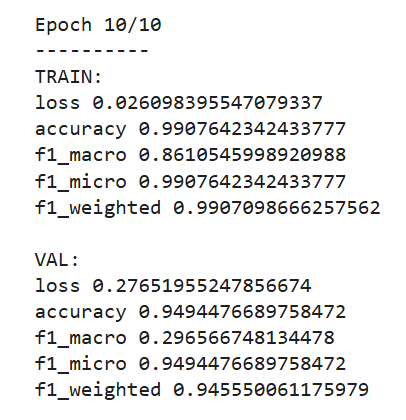

In [72]:
set_all_seeds(4036)

In [78]:
# замороженные эмбеддинги (обучаются только семантика)
class NERModelWithSemantics(nn.Module):
    def __init__(self, bert_model, num_labels, num_sem_classes, hidden_size=768):
        super().__init__()
        self.bert = bert_model
        self.num_sem_classes = num_sem_classes

        # Замораживаю BERT
        for param in self.bert.parameters():
            param.requires_grad = False

        # эмбеддинги для семантических классов (обучаю только семантические эмбеддинги)
        self.semantics = nn.Embedding(num_sem_classes, 100)
        for param in self.semantics.parameters():
            param.requires_grad = True

        # классификатор
        self.classifier = nn.Linear(hidden_size + 100, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids, semclasses, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )

        bert_output = outputs.last_hidden_state  # получается, что здесь у нас (B, T, H) - BERT эмбеддинги
        sem_embeddings = self.semantics(semclasses)  # а здесь находятся (B, T, D) - семантические эмбеддинги

        # вот тут у меня как раз происходит конкатенация эмбеддингов
        combined = torch.cat([bert_output, sem_embeddings], dim=-1)  #  # (B, T, H+D)
        logits = self.classifier(combined)  # (B, T, num_labels)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))

        return loss, logits

In [79]:
model = NERModelWithSemantics(
    bert_model=bert_model,
    num_labels=len(tag2idx),
    num_sem_classes=len(sem2id)
)
model.to(device)

NERModelWithSemantics(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [80]:
EPOCHS = 10
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001) # correct_bias=False пишет, что не поддерживается больше
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [81]:
from tqdm.auto import tqdm
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    all_preds = []
    all_targets = []
    losses = []
    correct_predictions = 0
    total_predictions = 0  # счетчик всех предсказаний

    batch_iterator = tqdm(data_loader, desc="Training", leave=False)

    for batch in batch_iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        semclasses = batch['semclasses'].to(device)
        labels = batch['labels'].to(device)

        loss, logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            semclasses=semclasses,
            labels=labels
        )

        preds = torch.argmax(logits, dim=2)
        mask = (labels != -100)

        correct_predictions += torch.sum((preds == labels) & mask)
        total_predictions += torch.sum(mask)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Переносим тензоры на CPU перед преобразованием в numpy
        all_preds.extend(preds[mask].cpu().numpy().flatten())
        all_targets.extend(labels[mask].cpu().numpy().flatten())

        batch_iterator.set_postfix(loss=loss.item())


    accuracy = correct_predictions.double() / total_predictions
    avg_loss = np.mean(losses)

    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    return accuracy.item(), avg_loss, f1_macro, f1_micro, f1_weighted

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    all_preds = []
    all_targets = []
    correct_predictions = 0
    total_predictions = 0

    batch_iterator = tqdm(data_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in batch_iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            semclasses = batch['semclasses'].to(device)
            labels = batch['labels'].to(device)

            loss, logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                semclasses=semclasses,
                labels=labels
            )

            preds = torch.argmax(logits, dim=2)
            mask = (labels != -100)

            correct_predictions += torch.sum((preds == labels) & mask)
            total_predictions += torch.sum(mask)
            losses.append(loss.item())

            all_preds.extend(preds[mask].cpu().numpy().flatten())
            all_targets.extend(labels[mask].cpu().numpy().flatten())

            batch_iterator.set_postfix(loss=loss.item())

    accuracy = correct_predictions.double() / total_predictions
    avg_loss = np.mean(losses)

    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    return accuracy.item(), avg_loss, f1_macro, f1_micro, f1_weighted

In [82]:
history = defaultdict(list)
best_accuracy = 0

In [83]:
# (основной цикл)
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss, f1_macro, f1_micro, f1_weighted = train_epoch(
        model,
        train_dataloader,
        optimizer,
        device,
        scheduler,
        len(train_data)
    )

    print(f'TRAIN:\nloss {train_loss}\naccuracy {train_acc}\nf1_macro {f1_macro}\nf1_micro {f1_micro}\nf1_weighted {f1_weighted}\n')

    val_acc, val_loss, val_f1_macro, val_f1_micro, val_f1_weighted = eval_model(
        model,
        valid_dataloader,
        device,
        len(val_data)
    )

    print(f'VAL:\nloss {val_loss}\naccuracy {val_acc}\nf1_macro {val_f1_macro}\nf1_micro {val_f1_micro}\nf1_weighted {val_f1_weighted}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.1277570146860348
accuracy 0.9483230497659881
f1_macro 0.6386764194126195
f1_micro 0.9483230497659881
f1_weighted 0.9456081168958791



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.22272301502525807
accuracy 0.9244871235268441
f1_macro 0.47112977833120323
f1_micro 0.9244871235268441
f1_weighted 0.9199912537615293


Epoch 2/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.11968218949106005
accuracy 0.952064001036454
f1_macro 0.6673601996169003
f1_micro 0.952064001036454
f1_weighted 0.950202303056334



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21913390122354032
accuracy 0.927251564091372
f1_macro 0.4746288875362471
f1_micro 0.927251564091372
f1_weighted 0.9223210312905884


Epoch 3/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.11378877612037791
accuracy 0.9550923901601646
f1_macro 0.6758259701521625
f1_micro 0.9550923901601646
f1_weighted 0.9533489074269921



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.22462693490087987
accuracy 0.9281245453222756
f1_macro 0.47705888528945645
f1_micro 0.9281245453222756
f1_weighted 0.9233166769157057


Epoch 4/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.10983907340301408
accuracy 0.9566956549903642
f1_macro 0.6817713048839796
f1_micro 0.9566956549903642
f1_weighted 0.9549246680090704



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21764015294611455
accuracy 0.9289975265531791
f1_macro 0.48439993926956737
f1_micro 0.9289975265531791
f1_weighted 0.9244248103531916


Epoch 5/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.10762879444907109
accuracy 0.958671395488186
f1_macro 0.6852197248868788
f1_micro 0.958671395488186
f1_weighted 0.9569941829560342



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21838099844753742
accuracy 0.9297250109122653
f1_macro 0.4879315999675445
f1_micro 0.9297250109122653
f1_weighted 0.9253625399383452


Epoch 6/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.10493222098383638
accuracy 0.959222011692497
f1_macro 0.6861174456684235
f1_micro 0.959222011692497
f1_weighted 0.9574809189428835



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.22148949578404425
accuracy 0.9301615015277171
f1_macro 0.488409013863868
f1_micro 0.9301615015277171
f1_weighted 0.9257468582961196


Epoch 7/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.10398637215710349
accuracy 0.959222011692497
f1_macro 0.6855010220704397
f1_micro 0.959222011692497
f1_weighted 0.9575880428420206



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.22280976101756095
accuracy 0.930597992143169
f1_macro 0.48942643620331644
f1_micro 0.930597992143169
f1_weighted 0.9262067120849381


Epoch 8/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.1054223692872458
accuracy 0.9588981198076082
f1_macro 0.6877259755455294
f1_micro 0.9588981198076082
f1_weighted 0.957276662767919



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.21713336370885372
accuracy 0.9307434890149862
f1_macro 0.49026510903307424
f1_micro 0.9307434890149862
f1_weighted 0.9264205240985773


Epoch 9/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.1082575041283336
accuracy 0.9587037846766749
f1_macro 0.6832479838214629
f1_micro 0.9587037846766749
f1_weighted 0.9569390224271485



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.2155804343521595
accuracy 0.9308889858868035
f1_macro 0.4910176470184526
f1_micro 0.9308889858868035
f1_weighted 0.9266496186739965


Epoch 10/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.11143789094769292
accuracy 0.9564041522939642
f1_macro 0.6730783523377352
f1_micro 0.9564041522939642
f1_weighted 0.9546738540978632



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.218041262216866
accuracy 0.9308889858868035
f1_macro 0.4910176470184526
f1_micro 0.9308889858868035
f1_weighted 0.9266496186739965



In [84]:
set_all_seeds(4036)

In [91]:
# замороженные эмбеддинги (обучаются только эмбеддинги BERT)
class NERModelWithSemantics(nn.Module):
    def __init__(self, bert_model, num_labels, num_sem_classes, hidden_size=768):
        super().__init__()
        self.bert = bert_model
        self.num_sem_classes = num_sem_classes

        # BERT
        for param in self.bert.parameters():
            param.requires_grad = True

        # эмбеддинги для семантических классов не обучаю
        self.semantics = nn.Embedding(num_sem_classes, 100)
        for param in self.semantics.parameters():
            param.requires_grad = False

        # классификатор
        self.classifier = nn.Linear(hidden_size + 100, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids, semclasses, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )

        bert_output = outputs.last_hidden_state  # получается, что здесь у нас (B, T, H) - BERT эмбеддинги
        sem_embeddings = self.semantics(semclasses)  # а здесь находятся (B, T, D) - семантические эмбеддинги

        # вот тут у меня как раз происходит конкатенация эмбеддингов
        combined = torch.cat([bert_output, sem_embeddings], dim=-1)  #  # (B, T, H+D)
        logits = self.classifier(combined)  # (B, T, num_labels)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))

        return loss, logits

In [92]:
model = NERModelWithSemantics(
    bert_model=bert_model,
    num_labels=len(tag2idx),
    num_sem_classes=len(sem2id)
)
model.to(device)

NERModelWithSemantics(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [93]:
EPOCHS = 10
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001) # correct_bias=False пишет, что не поддерживается больше
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [94]:
from tqdm.auto import tqdm
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    all_preds = []
    all_targets = []
    losses = []
    correct_predictions = 0
    total_predictions = 0  # счетчик всех предсказаний

    batch_iterator = tqdm(data_loader, desc="Training", leave=False)

    for batch in batch_iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        semclasses = batch['semclasses'].to(device)
        labels = batch['labels'].to(device)

        loss, logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            semclasses=semclasses,
            labels=labels
        )

        preds = torch.argmax(logits, dim=2)
        mask = (labels != -100)

        correct_predictions += torch.sum((preds == labels) & mask)
        total_predictions += torch.sum(mask)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Переносим тензоры на CPU перед преобразованием в numpy
        all_preds.extend(preds[mask].cpu().numpy().flatten())
        all_targets.extend(labels[mask].cpu().numpy().flatten())

        batch_iterator.set_postfix(loss=loss.item())


    accuracy = correct_predictions.double() / total_predictions
    avg_loss = np.mean(losses)

    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    return accuracy.item(), avg_loss, f1_macro, f1_micro, f1_weighted

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    all_preds = []
    all_targets = []
    correct_predictions = 0
    total_predictions = 0

    batch_iterator = tqdm(data_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in batch_iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            semclasses = batch['semclasses'].to(device)
            labels = batch['labels'].to(device)

            loss, logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                semclasses=semclasses,
                labels=labels
            )

            preds = torch.argmax(logits, dim=2)
            mask = (labels != -100)

            correct_predictions += torch.sum((preds == labels) & mask)
            total_predictions += torch.sum(mask)
            losses.append(loss.item())

            all_preds.extend(preds[mask].cpu().numpy().flatten())
            all_targets.extend(labels[mask].cpu().numpy().flatten())

            batch_iterator.set_postfix(loss=loss.item())

    accuracy = correct_predictions.double() / total_predictions
    avg_loss = np.mean(losses)

    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    return accuracy.item(), avg_loss, f1_macro, f1_micro, f1_weighted

In [95]:
history = defaultdict(list)
best_accuracy = 0

In [96]:
# (основной цикл)
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss, f1_macro, f1_micro, f1_weighted = train_epoch(
        model,
        train_dataloader,
        optimizer,
        device,
        scheduler,
        len(train_data)
    )

    print(f'TRAIN:\nloss {train_loss}\naccuracy {train_acc}\nf1_macro {f1_macro}\nf1_micro {f1_micro}\nf1_weighted {f1_weighted}\n')

    val_acc, val_loss, val_f1_macro, val_f1_micro, val_f1_weighted = eval_model(
        model,
        valid_dataloader,
        device,
        len(val_data)
    )

    print(f'VAL:\nloss {val_loss}\naccuracy {val_acc}\nf1_macro {val_f1_macro}\nf1_micro {val_f1_micro}\nf1_weighted {val_f1_weighted}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.13296190216723416
accuracy 0.9462987254854329
f1_macro 0.6264163173093015
f1_micro 0.9462987254854329
f1_weighted 0.9438910276209336



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.23166304975748062
accuracy 0.9257965953731995
f1_macro 0.4787591821526612
f1_micro 0.9257965953731995
f1_weighted 0.921032270150956


Epoch 2/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.1113640306931403
accuracy 0.9551895577256312
f1_macro 0.6878408619603894
f1_micro 0.9551895577256312
f1_weighted 0.9537756308729233



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.22453523762524127
accuracy 0.9282700421940928
f1_macro 0.4787534310417013
f1_micro 0.9282700421940928
f1_weighted 0.922980600024103


Epoch 3/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.09612214909866452
accuracy 0.9621208440622521
f1_macro 0.7325386659826789
f1_micro 0.9621208440622521
f1_weighted 0.9612679603352213



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.23302656933665275
accuracy 0.9294340171686308
f1_macro 0.49500833299717645
f1_micro 0.9294340171686308
f1_weighted 0.9240768271764404


Epoch 4/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.08375896693517765
accuracy 0.9665419682909845
f1_macro 0.7646937529202649
f1_micro 0.9665419682909845
f1_weighted 0.9659373371291946



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.23442300818860531
accuracy 0.9342354139386003
f1_macro 0.528532451552042
f1_micro 0.9342354139386003
f1_weighted 0.9295224275776119


Epoch 5/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.07390402606171038
accuracy 0.9708659249542503
f1_macro 0.79199999676334
f1_micro 0.9708659249542503
f1_weighted 0.9705208496790539



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.23757695704698562
accuracy 0.9320529608613415
f1_macro 0.5326519839496825
f1_micro 0.9320529608613415
f1_weighted 0.9281363244349468


Epoch 6/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.0679314642213285
accuracy 0.973975287049183
f1_macro 0.8130408018170349
f1_micro 0.973975287049183
f1_weighted 0.9736076618456017



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.24330496061593293
accuracy 0.9291430234249963
f1_macro 0.5558282972776553
f1_micro 0.9291430234249963
f1_weighted 0.9293638676694284


Epoch 7/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.06112638398384054
accuracy 0.9761129734894493
f1_macro 0.8301427380751148
f1_micro 0.9761129734894493
f1_weighted 0.9758853777975333



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.2501634776592255
accuracy 0.9298705077840826
f1_macro 0.5257117150931293
f1_micro 0.9298705077840826
f1_weighted 0.9278889730439885


Epoch 8/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.057419683101276556
accuracy 0.9777324329138933
f1_macro 0.8371983784825511
f1_micro 0.9777324329138933
f1_weighted 0.9775367258900995



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.2522401764988899
accuracy 0.9342354139386003
f1_macro 0.5570334776191318
f1_micro 0.9342354139386003
f1_weighted 0.93171611127864


Epoch 9/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.05665892026024974
accuracy 0.9786879139743154
f1_macro 0.8429690536909809
f1_micro 0.9786879139743154
f1_weighted 0.9784740086056737



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.2450348200276494
accuracy 0.9337989233231485
f1_macro 0.55068898836951
f1_micro 0.9337989233231485
f1_weighted 0.9315256569036081


Epoch 10/10
----------


Training:   0%|          | 0/180 [00:00<?, ?it/s]

TRAIN:
loss 0.054500861398668755
accuracy 0.9793680869325819
f1_macro 0.8524419496216626
f1_micro 0.9793680869325819
f1_weighted 0.9792241973296779



Validation:   0%|          | 0/20 [00:00<?, ?it/s]

VAL:
loss 0.24989217817783355
accuracy 0.9336534264513313
f1_macro 0.5492119019847334
f1_micro 0.9336534264513313
f1_weighted 0.9314197745901867



**(Попробую еще class_weight потом добавить)**